# Lab 4 - Lead Compensators

# Objectives

The objectives of this lab are:
- Design a Lead Compensator,
- Design a controller on a linearized plant, but investigate how it will operate on the nonlinear plant.

The plant in this lab is that same as the one used in Lab 3 - a pendulum attached to a motor as shown below.    

![pendulum](pendulum.png "pendulum")

The objective is to design a controller that will move the pendulum to a specific angle with minimal overshoot and ringing by applying a torque using the motor.

# Derivation of Plant Equations

The free body diagram for the system is shown below. 

![freeBodyDiagram](freeBodyDiagram.png "freeBodyDiagram")

In the free body diagram, $T_g$ is the torque due to gravity, and $T_m$ is the torque applied by the motor. 
The rotational inertia for a weight on the end of a massless rod is $J=mL^2$. Recall that torque is equal to force times the length of the lever. Therefore, in this case we have:
$$
\begin{align*}
    T_g(t)&=gmL \sin(\theta(t)), \\
    T_m (t)&=k_T i(t),
\end{align*}
$$
where 
-$i(t)$  is the current through the motor,
-$\theta(t)$ is the angle of the pendulum (where $\theta=0$ is pointing downwards),
-$k_T$ is the usual torque constant,
-$m$ is the mass of the weight at the end of the pendulum,
-$L$ is the length of the pendulum,
-$g$ is the gravitational constant ($9.81$ m/s^2).

Summing the torques we get the expression:
$$
\begin{align*} 
T_m - T_g &= J \alpha   \\
k_T i(t) - gmL\sin(\theta(t)) &= mL^2 \frac{d^2 \theta}{dt^2}
\end{align*}
$$
Note that this is a nonlinear differential equation. Why? 

When the pendulum is in the downward vertical position, the angle is $0$. Let us linearize the system around this point. If $\theta$ is close to zero, then
$$
\begin{align*}
\sin(\theta)\approx \theta. 
\end{align*}
$$

Plug this into the differential equation:
$$
\begin{align*} 
    k_T i(t) - gmL\theta(t) &= mL^2 \frac{d^2 \theta}{dt^2}
\end{align*}
$$
which is an ordinary (linear) differential equation. 

Taking the Laplace Transform of both sides we end up with the following transfer function:
$$
\begin{align*}
    \frac{\theta(s)}{I(s)} = \frac{k_T}{mL^2s^2+gmL}
\end{align*}
$$

The values for $k_T$, $m$, $g$ and $L$ are:
- $k_T = 1$
- $m = \frac{1}{0.981^2}$,
- $g = 9.81$,
- $L = 0.981$,


# Objective of the controller

We will be designing the controller based on a linearized approximation of the nonlinear differential equations governing the pendulum. In addition we will be imposing a limit as to how much current the current source can supply. However, we will test out final control design on the nonlinear system. 

Last lab we designed a PID controller to control the system, this week we will design a Lead controller. Recall that the PID design method is a lot of trial and error. In Lead compensator design the trial and error is replaced with math.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import control as ct
import enel441_utilities as eu

In [3]:
kT = 1
m = 1/0.981**2
g = 9.81
L = 0.981
P = ct.tf(kT/L**2/m, [1, 0, g/L])

print('Plant transfer function:')
print(P)

Plant transfer function:

   1
--------
s^2 + 10



# Lead Compensator Design

In this section we will design a Lead Compensator. Our objective is to design a Lead Compensator using the Root Locus approach


# Question 1

Similar to last lab, we would like a closed-loop system with a 2\% settling time equal to 0.5 seconds. Design the system so that the stability margin is $1.1$. Where should we attempt to place the (dominant) closed loop poles?

# Question 2 

Make a Root Locus plot of the uncompensated system. Use the code below.

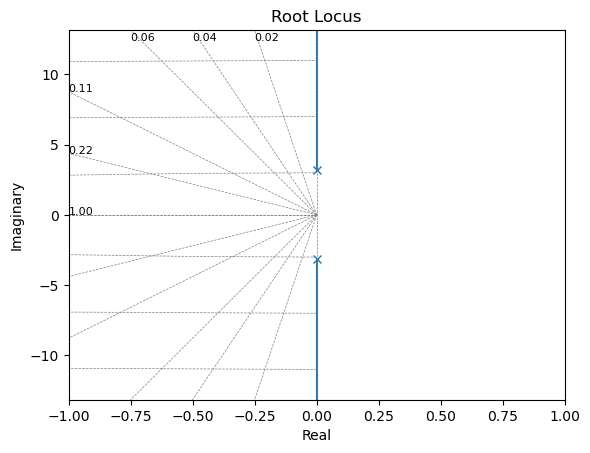

In [4]:
cl_poles, gain = ct.root_locus(P)

# Question 3

How much phase needs to be added at the desired closed-loop pole location? Recall that a Lead Compensator can only practically add 60-70 degrees of phase. Is this enough? 


# Question 4
Use the Root Locus approach to design a Lead Compensator that will add half of the required phase. Then we will use two identical lead compensators in series to add the correct amount of phase at the desired closed-loop pole location.  

# Question 5

Make a root locus plot of the new closed loop system. Verify that the desired closed-loop poles lie on the Root Locus. 

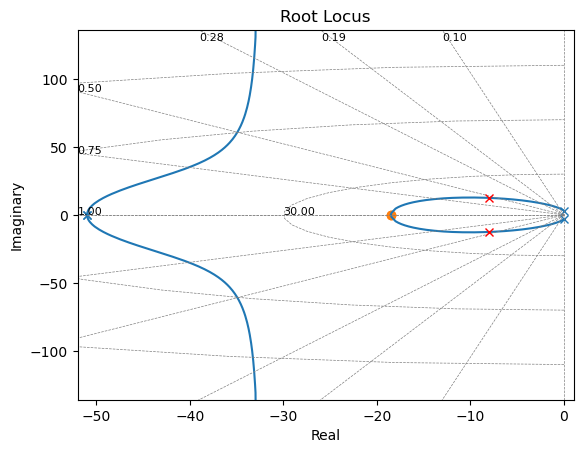

In [9]:
# K_lead = ct.tf([],[])  # fill in your Lead Compensator here

# Coefficients for the individual first-order terms in the numerator and denominator
num_first_order = [1, 18.5]
den_first_order = [1, 51]

# Creating the first-order transfer functions and raising them to the fourth power
num = ct.tf(num_first_order, [1])**2
den = ct.tf(den_first_order, [1])**2

# Controller gain
k_gain = 1628.45

# Combine the terms to create the controller K(s)
K_lead = k_gain * num / den


desired_closed_loop_pole = complex(-8 ,12.5 ) # type in the real and imaginary part of your desired closed loop pole location
fig, ax = plt.subplots(1)
cl_poles, gain = ct.root_locus(P*K_lead)
ax.plot(np.real(desired_closed_loop_pole), np.imag(desired_closed_loop_pole), 'rx')
ax.plot(np.real(desired_closed_loop_pole), -np.imag(desired_closed_loop_pole), 'rx')

# Question 6

Simulate the response to a step of 5 degrees. Verify that the complementary sensitivity function has the desired closed loop poles. Does the closed loop system have the required characteristics?

Poles of complementary sensitivity function:
 [-4.29983446e+01+2.81709331e+01j -4.29983446e+01-2.81709331e+01j
 -5.10000000e+01+3.41888502e-06j -5.10000000e+01-3.41888502e-06j
 -8.00165541e+00+1.25192913e+01j -8.00165541e+00-1.25192913e+01j
  8.88178420e-16+3.16227766e+00j  8.88178420e-16-3.16227766e+00j]


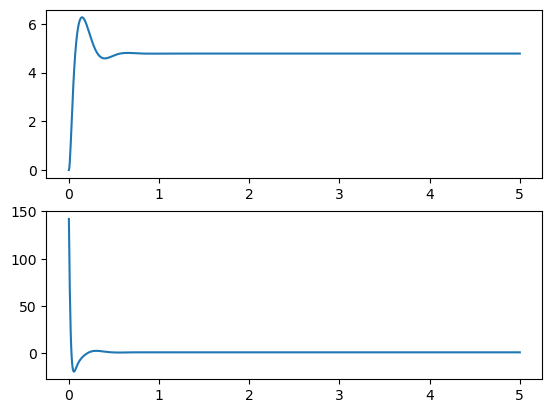

In [10]:
T = P*K_lead/(1+P*K_lead)
S = 1/(1+P*K_lead)

print('Poles of complementary sensitivity function:\n', T.poles())

t = np.linspace(0,5,1000)
r = 5*np.pi/180 * np.ones(t.shape)
t,y_lin2 = ct.forced_response(T,t,r)
t,u_lin2 = ct.forced_response(K_lead*S,t,r)

fig, ax = plt.subplots(2,1)
ax[0].plot(t,y_lin2*180/np.pi)
ax[1].plot(t,u_lin2)

# Question 7

Make plots of the Sensitivity, Complementary Sensitivity, $K S$ and $P S$ for the Lead Compensator that you designed. What are the advantages, disadvantages of your design?

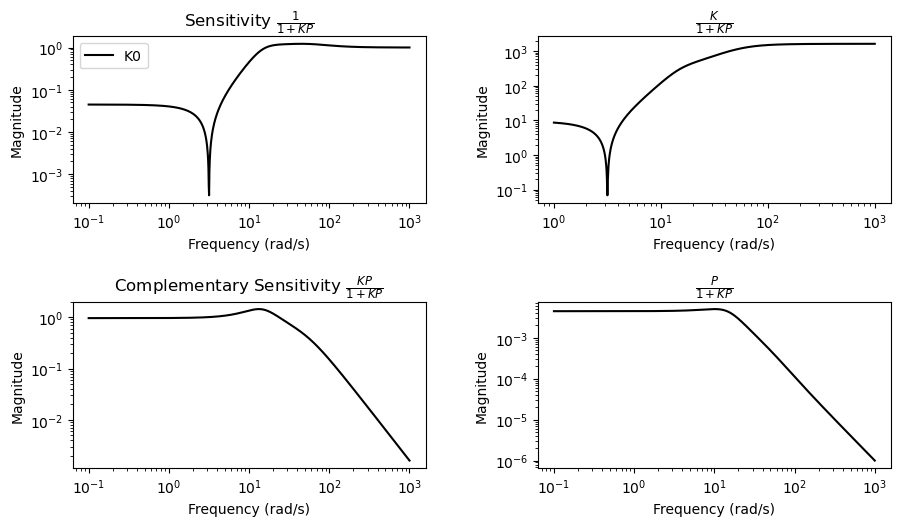

In [11]:
fig, ax = eu.plot_gang_of_four(P,[K_lead])

# Question 8

Now, let's try the Lead Compensator that you designed based on the linearized model on the nonlinear model. Use the code below to simulate the output when using the nonlinear model. 

In [12]:
# Some functions to run a simulation of the nonlinear system

def pendulum_update(t, x, u, params={}): 
    m = params.get('m', 1/0.981**2)
    g = params.get('g', 9.81)
    L = params.get('L', 0.981)
    max_Torque = params.get('max_Torque', 2)

    theta_pend = x[0]  
    dtheta_pend = x[1]

    torque_applied = np.clip(u[0], -max_Torque, max_Torque)  
    #torque_applied = u[0]
    J = m*L**2
    ddtheta_pend = torque_applied/J - L*m*g/J*np.sin(theta_pend)
    dx = np.array([dtheta_pend, ddtheta_pend])
    return dx

def pendulum_out(t,x,u,params={}):
    return x[0]
    
def simulate_closed_loop_pendulum(K,t,r,x0):
    pendulum = ct.NonlinearIOSystem(
        pendulum_update, pendulum_out, name='pendulum',
        inputs=('Tm'), outputs=('theta'), states=('theta', 'dtheta'))
    controller = ct.tf2io(K,name='controller', inputs='u', outputs='y')

    closed_loop_system = ct.InterconnectedSystem(
        (controller, pendulum), name='pendulum',
        connections=(
            ['controller.u', '-pendulum.theta'],
            ['pendulum.Tm', 'controller.y']),
        inplist=('controller.u'),
        inputs=('ref'),
        outlist=('pendulum.theta', 'controller.y'),
        outputs=('theta', 'Tm'))

    t, y_nonlin = ct.input_output_response(
            closed_loop_system, t, r, x0)
    return t,y_nonlin

Text(0.5, 0, 'Time (s)')

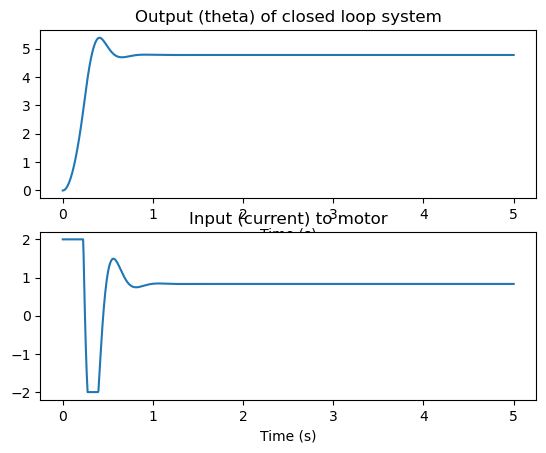

In [13]:
x0 = np.array([0,0])
t,y_nonlin2 = simulate_closed_loop_pendulum(K_lead,t,r,x0)
fig,ax = plt.subplots(2,1)
ax[0].plot(t,y_nonlin2[0]*180/np.pi)
ax[0].set_title('Output (theta) of closed loop system')
ax[0].set_xlabel('Time (s)')

ax[1].plot(t,np.clip(y_nonlin2[1],-2,2))
ax[1].set_title('Input (current) to motor')
ax[1].set_xlabel('Time (s)')

# Question 9

See what the maximum angle is that you can achieve using your controller and the current limited motor.

Text(0.5, 0, 'Time (s)')

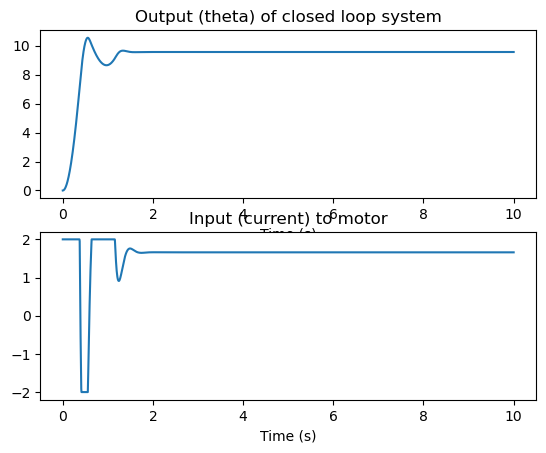

In [15]:
x0 = np.array([0,0])
t = np.linspace(0,10,2000)
r = 10*np.pi/180 * np.ones(t.shape)
t,y_nonlin_180 = simulate_closed_loop_pendulum(K_lead,t,r,x0)


fig,ax = plt.subplots(2,1)
ax[0].plot(t,y_nonlin_180[0]*180/np.pi)
ax[0].set_title('Output (theta) of closed loop system')
ax[0].set_xlabel('Time (s)')

ax[1].plot(t,np.clip(y_nonlin_180[1],-2,2))
ax[1].set_title('Input (current) to motor')
ax[1].set_xlabel('Time (s)')